<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/Tutorial3(Lapicque's%20RC%20model%2C%20nn.Linear%2C%20nn.Leaky).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 KB 5.5 MB/s eta 0:00:00


In [3]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

The decay rate is: 0.819
R is: 1.00Ohm
C is: 5000000.00nF
Weight is: 0.40


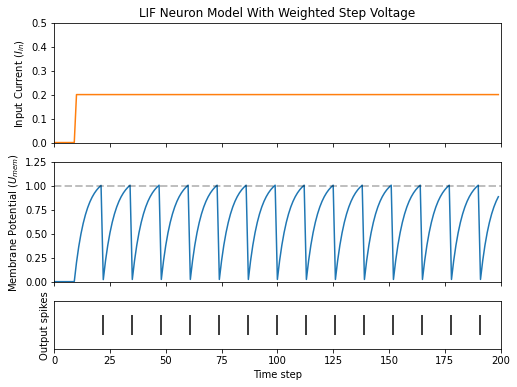

In [5]:
# ///////////////////////////////////////////// 1. Simplifying the Leaky Integrate-and-Fire Neuron Model //////////////////////////////////////



# # threshold=1, time_step=1e-3, R=5.1, C=5e-3
# # beta=1-w;
# R=1.8000015; C=5e-3; time_step=1e-3;  threshold=1;
# delta_t = torch.tensor(time_step)
# tau = torch.tensor(R*C)
# beta = torch.exp(-delta_t/tau)      #      beta: ratio of membrane potential between subsequent steps
# w=(time_step/(R*C))

# def leaky_integrate_and_fire(mem, x, w, beta, threshold, time_step, R, C):
#   spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
#   mem = (1-(w) * mem) + ((w)*x*R) - (spk*threshold)
#   return spk, mem

# set neuronal parameters
R=1; C=5e-3; time_step=1e-3; 
delta_t = torch.tensor(time_step)
tau = torch.tensor(R*C)
beta = torch.exp(-delta_t/tau)      #      beta: ratio of membrane potential between subsequent steps
w=2*(time_step/(tau))

def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x*R - spk*threshold
  return spk, mem

print(f"The decay rate is: {beta:.3f}")
print(f"R is: {R:.2f}Ohm")
print(f"C is: {(C*1e9):.2f}nF")
print(f"Weight is: {w:.2f}")

num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []


# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta) #, threshold=threshold, time_step=time_step, R=R, C=C)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w*R, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# plot_cur_mem_spk(x*w*R, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
#                  title="LIF Neuron Model With Weighted Step Voltage")
  

In [6]:
# # lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)
# # ///////////////////////////////////////////// 2. Leaky Neuron Model in snnTorch //////////////////////////////////////
# # We assume the input current has already been weighted before passing into the snn.Leaky neuron. 
# # This model has the same optional input arguments of reset_mechanism and threshold as described for Lapicque's neuron model.

# lif1 = snn.Leaky(beta=0.8)
# # Small step current input
# w=0.21
# cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
# mem = torch.zeros(1)
# spk = torch.zeros(1)
# mem_rec = []
# spk_rec = []

# # neuron simulation
# for step in range(num_steps):
#   spk, mem = lif1(cur_in[step], mem)
#   mem_rec.append(mem)
#   spk_rec.append(spk)

# # convert lists to tensors
# mem_rec = torch.stack(mem_rec)
# spk_rec = torch.stack(spk_rec)

# plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
#                  title="snn.Leaky Neuron Model")

 
The spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place
 


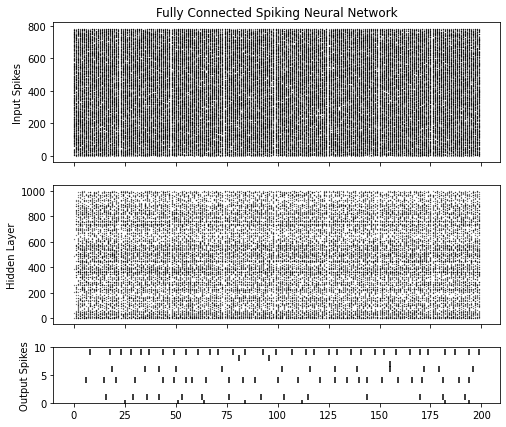

In [13]:

# # ///////////////////////////////////////////// 3. A Feedforward Spiking Neural Network //////////////////////////////////////

#    snnTorch makes it straightforward to scale this up to a deep neural network. 
# In this section, you will create a 3-layer fully-connected neural network of dimensions 784(input)-1000(hidden)-10(output). 
# Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes.

# Connections are generated by PyTorch:  nn.Linear(), nn.Conv2d(), ...
# Neurons are generated by snnTorch: snn.Lapicque(), snn.Synaptic(), snn.Leaky(), snn.Alpha()

# PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models.
#  In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.


#---------------------- First, initialize all layers
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers (connections)
fc1 = nn.Linear(num_inputs, num_hidden)
# with torch.no_grad():
            # self.linear.weight = torch.tensor(weights) # nn.Parameter(...) ?

lif1 = snn.Leaky(beta=beta)        # Neurons (input)
# lif1 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)


fc2 = nn.Linear(num_hidden, num_outputs)    #   connection
lif2 = snn.Leaky(beta=beta)


#---------------------------- Next, initialize the hidden variables and outputs of each spiking neuron. 
# Initialize hidden states
mem1 = lif1.init_leaky()
# mem1 = lif1.init_Lapicque()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []


#-------------------- Create an input spike train to pass to the network. 
# There are 200 time steps to simulate across 784 input neurons, i.e.,
#  the input originally has dimensions of 200×784. However, neural nets typically process data in minibatches. snnTorch uses time-first dimensionality: [time * batch_size * feature_dimensions]
# So 'unsqueeze' the input along dim=1 to indicate 'one batch' of data. The dimensions of this input tensor must be 200 * 1 * 784

spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
# print(f"Dimensions of spk_in: {spk_in.size()}")


#  The ith input from spk_in to the jth neuron is weighted by the parameters initialized in nn.Linear: Xi * Wij
# we are now scaling the input current with a weight generated by nn.Linear, rather than manually setting (w) ourselves:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

# The spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place
print(' ')
print("     The spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place")
print(' ')

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")



In [ ]:
# "spikeplot.spike_count" can create a spike counter of the output layer. The following animation will take some time to generate. 

from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

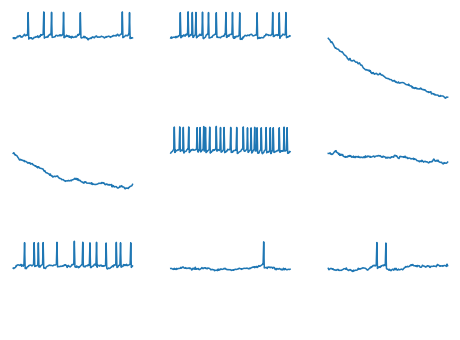

In [20]:

#------------------------ "spikeplot.traces" lets us visualize the membrane potential traces-------------------------------------
#  You will plot 9 out of 10 output neurons. Compare it to the animation and raster plot above to see if you can match the traces to the neuron.

# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(0))
# splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)